In [1]:
from lmfit import minimize, Minimizer, Parameters, Parameter, report_fit
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from tqdm import tqdm
import matplotlib.cm as cm
from read_data import read_data,read_wds,read_orb6
from astrometry_model import astrometry_model,triple_model,quad_model,lnlike,lnprior,lnpost,create_init
from orbit_plotting import orbit_model,triple_orbit_model
from astroquery.simbad import Simbad
from astropy.coordinates import SkyCoord
import random
from PyAstronomy import pyasl
%matplotlib inline

In [2]:
def cart2pol(x,y):
    x=-x
    r = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y,x) * 180 / np.pi
    if theta>0 and theta<90:
        theta_new = theta+270
    if theta>90 and theta<360:
        theta_new = theta-90
    if theta<0:
        theta_new = 270+theta
    if np.isnan(theta):
        theta_new=theta
    return(r,theta_new)

In [3]:
def add_planet(period,wobble,bigomega,inc,t0,epochs):
    omega = 0
    ecc = 0
    bigomega = bigomega
    inc = inc

    ## other method:
    ke = pyasl.KeplerEllipse(wobble,period,e=ecc,Omega=bigomega,i=inc,w=omega,tau=t0)
    pos = ke.xyzPos(epochs)
    xx = pos[::,1]
    yy = pos[::,0]
    return(xx,yy)

In [28]:
def triple_model_sinusoid(params, data_x, data_y, t, error_maj, error_min, error_pa):
   
   #orbital parameters:
    w = params['w']
    bigw = params['bigw']
    inc = params['inc']
    e = params['e']
    a = params['a']
    P = params['P']
    T = params['T']
    mirc_scale = params['mirc_scale']
    #mratio = params['mratio']
    
    ## inner orbit
    omega = params['omega']
    phase_x = params['phase_x']
    phase_y = params['phase_y']
    a_x = params['a_x']
    a_y = params['a_y']

    ## polynomial + kepler inner
    ke = pyasl.KeplerEllipse(a,P,e=e,Omega=bigw,i=inc,w=w,tau=T)
    pos = ke.xyzPos(t)
    
    model_y = pos[::,0] + a_y*np.sin(omega*t+phase_y)
    model_x = pos[::,1] + a_x*np.sin(omega*t+phase_x)
    
    #idx = np.where((t<58362) & (t>57997))
    idx = np.where(t<58757)
    model_y[idx]/=mirc_scale
    model_x[idx]/=mirc_scale
    
    major_vector_x=np.sin(error_pa)
    major_vector_y=np.cos(error_pa)
    minor_vector_x=-major_vector_y
    minor_vector_y=major_vector_x
    resid_x=data_x-model_x
    resid_y=data_y-model_y
    resid_major=(resid_x*major_vector_x+resid_y*major_vector_y)/error_maj
    resid_minor=(resid_x*minor_vector_x+resid_y*minor_vector_y)/error_min
    resids=np.concatenate([resid_major,resid_minor])
    return (resids)

#astrometry model for fitting x,y,t data with error ellipses
def quad_model_sinusoid(params, data_x, data_y, t, error_maj, error_min, error_pa):
   
    #orbital parameters:
    w = params['w']
    bigw = params['bigw']
    inc = params['inc']
    e = params['e']
    a = params['a']
    P = params['P']
    T = params['T']
    mirc_scale = params['mirc_scale']
    #mratio = params['mratio']
    
    ## inner orbit
    omega = params['omega']
    phase_x = params['phase_x']
    phase_y = params['phase_y']
    a_x = params['a_x']
    a_y = params['a_y']
    
    ## inner orbit
    omega_2 = params['omega_2']
    phase_x_2 = params['phase_x_2']
    phase_y_2 = params['phase_y_2']
    a_x_2 = params['a_x_2']
    a_y_2 = params['a_y_2']

    ## polynomial + kepler inner
    ke = pyasl.KeplerEllipse(a,P,e=e,Omega=bigw,i=inc,w=w,tau=T)
    pos = ke.xyzPos(t)
    
    model_y = pos[::,0] + a_y*np.sin(omega*t+phase_y) + a_y_2*np.sin(omega_2*t+phase_y_2)
    model_x = pos[::,1] + a_x*np.sin(omega*t+phase_x) + a_x_2*np.sin(omega_2*t+phase_x_2)
    
    #idx = np.where((t<58362) & (t>57997))
    idx = np.where(t<58757)
    model_y[idx]/=mirc_scale
    model_x[idx]/=mirc_scale
    
    major_vector_x=np.sin(error_pa)
    major_vector_y=np.cos(error_pa)
    minor_vector_x=-major_vector_y
    minor_vector_y=major_vector_x
    resid_x=data_x-model_x
    resid_y=data_y-model_y
    resid_major=(resid_x*major_vector_x+resid_y*major_vector_y)/error_maj
    resid_minor=(resid_x*minor_vector_x+resid_y*minor_vector_y)/error_min
    resids=np.concatenate([resid_major,resid_minor])
    return (resids)

In [5]:
## setup paths for user
path = '/Users/tgardne/ARMADA_orbits'
path_etalon = '/Users/tgardne/etalon_epochs/etalon_fits/etalon_factors_fit.txt'
path_wds = '/Users/tgardne/wds_targets'
path_orb6 = '/Users/tgardne/catalogs/orb6orbits.sql.txt'

In [6]:
###########################################
## Specify Target
###########################################
target_hd = '140159'

emethod = 'n'
mirc_scale = 'n'

query = Simbad.query_objectids('HD %s'%target_hd)
for item in query:
    if 'HIP' in item[0]:
        target = item[0].split()[1]
        print('HIP %s'%target)
    if 'WDS' in item[0]:
        target_wds = item[0][5:15]
        print('WDS %s'%target_wds)

try:
    print(target_wds)
except:
    print('No WDS number queried')
    target_wds = input('Enter WDS: ')

HIP 76852
WDS 15416+1940
15416+1940


In [7]:
###########################################
## Read in ARMADA data
###########################################
if emethod == 'y':
    print('reading bootstrap errors')
    file=open('%s/HD_%s_bootstrap.txt'%(path,target_hd))
else:
    print('reading chi2 errors')
    file=open('%s/HD_%s_chi2err.txt'%(path,target_hd))
weight=1

t,p,theta,error_maj,error_min,error_pa,error_deg = read_data(file,weight)
file.close()

reading chi2 errors


In [8]:
### correct PAs based on precession
coord = SkyCoord.from_name("HD %s"%target_hd,parse=True)
ra = coord.ra.value*np.pi/180
dec = coord.dec.value*np.pi/180
#theta -= (0.00557*np.sin(ra)/np.cos(dec)*((t-51544.5)/365.25))/180*np.pi

In [9]:
###########################################
## Apply etalon correction
###########################################
file=open(path_etalon)
mjd_etalon=[]
f_etalon=[]
for line in file.readlines():
    if line.startswith('#'):
        continue
    mjd_etalon.append(float(line.split()[0]))
    f_etalon.append(float(line.split()[1]))
file.close()
mjd_etalon=np.array(mjd_etalon)
f_etalon=np.array(f_etalon)

etalon_factor=[]
for i in t:
    idx = np.where(abs(i-mjd_etalon)==min(abs(i-mjd_etalon)))
    if min(abs(i-mjd_etalon))>0.5:
        print('Closest factor for %s is %s days away'%(i,min(abs(i-mjd_etalon))))
    f = f_etalon[idx][0]
    etalon_factor.append(f)
etalon_factor=np.array(etalon_factor)

print('   date      etalon factor')
for i,j in zip(t,etalon_factor):
    print(i,j)

## apply etalon correction
etalon = 'y'

vlti = 'n'
if vlti=='y':
    vlti_idx = input('enter indices (e.g. 1 2 3): ').split(' ')
    vlti_idx = np.array([int(i) for i in vlti_idx])
else:
    vlti_idx = np.array([])

if etalon=='y':
    print('Applying etalon correction')
    if len(vlti_idx)>0:
        etalon_factor[vlti_idx] = 1.0
    p = p/etalon_factor
else:
    print('No etalon correction applied')
xpos=p*np.sin(theta)
ypos=p*np.cos(theta)

Closest factor for 58222.3507 is 0.8345060481951805 days away
   date      etalon factor
58223.4082 1.0031541612041177
58158.571 1.0032724870074572
59042.1973 1.0000802864218061
58636.3086 0.9999251439725149
58635.2767 0.9999215780162495
59044.2481 1.0001204100790912
59004.2807 1.0001504589939723
58703.1746 0.9999772819268882
58222.3507 1.0031541612041177
59196.598 1.0001933926299817
58693.1558 0.9999843769059221
59304.4024 1.0000918459270567
Applying etalon correction


Number of WDS data points = 48


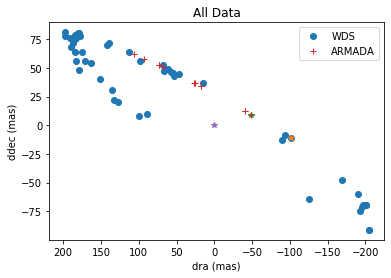

In [10]:
###########################################
## Read in WDS data - and plot to check
###########################################
file=open(os.path.expanduser("%s/wds%s.txt"%(path_wds,target_wds)))
weight = 10
dtype = 'S'

t_wds,p_wds,theta_wds,error_maj_wds,error_min_wds,error_pa_wds,error_deg_wds = read_wds(file,weight,dtype)
print('Number of WDS data points = %s'%len(p_wds))

## correct WDS for PA
theta_wds -= (0.00557*np.sin(ra)/np.cos(dec)*((t_wds-51544.5)/365.25))/180*np.pi

xpos_wds=p_wds*np.sin(theta_wds)
ypos_wds=p_wds*np.cos(theta_wds)
idx = np.argmin(t)

plt.plot(xpos_wds,ypos_wds,'o',label='WDS')
plt.plot(xpos_wds[0],ypos_wds[0],'*')
plt.plot(xpos[idx],ypos[idx],'*')
plt.plot(xpos,ypos,'+',label='ARMADA')
plt.plot(0,0,'*')
plt.gca().invert_xaxis()
plt.title('All Data')
plt.xlabel('dra (mas)')
plt.ylabel('ddec (mas)')
plt.legend()
plt.show()

In [11]:
###########################################
## Get an estimate of the orbital parameters
###########################################
try:
    a,P,e,inc,omega,bigomega,T = read_orb6(target,path_orb6)
except:
    print('No elements found in ORB6')

found target!
--------------------------
a(mas),P(yr),e,i(deg),omega(deg),bigomega(deg),T(mjd)
210.32999999999998 21.958904109589042 0.0941 83.608 80.5 69.684 54180.0
--------------------------


In [12]:
###########################################
## Combined WDS+ARMADA for fitting
###########################################
xpos_all = np.concatenate([xpos,xpos_wds])
ypos_all = np.concatenate([ypos,ypos_wds])
t_all = np.concatenate([t,t_wds])
error_maj_all = np.concatenate([error_maj,error_maj_wds])
error_min_all = np.concatenate([error_min,error_min_wds])
error_pa_all = np.concatenate([error_pa,error_pa_wds])
error_deg_all = np.concatenate([error_deg,error_deg_wds])

In [13]:
############################################
## ADD A FAKE PLANET
############################################
print('ADDING FAKE PLANET')
pper = 100
psem = 0.5

pper2 = 5
psem2 = 0.5

bigw_injected1 = np.random.uniform(0,360)
inc_injected1 = np.random.uniform(0,180)
t0_injected1 = np.random.uniform(min(t),max(t))
bigw_injected2 = np.random.uniform(0,360)
inc_injected2 = np.random.uniform(0,180)
t0_injected2 = np.random.uniform(min(t),max(t))

planet_xy = add_planet(pper,psem,bigw_injected1,inc_injected1,t0_injected1,t)
planet_xy_wds = add_planet(pper,psem,bigw_injected1,inc_injected1,t0_injected1,t_wds)
planet_xy_all = add_planet(pper,psem,bigw_injected1,inc_injected1,t0_injected1,t_all)
planet_xy2 = add_planet(pper2,psem2,bigw_injected2,inc_injected2,t0_injected2,t)
planet_xy2_wds = add_planet(pper2,psem2,bigw_injected2,inc_injected2,t0_injected2,t_wds)
planet_xy2_all = add_planet(pper2,psem2,bigw_injected2,inc_injected2,t0_injected2,t_all)

xpos += planet_xy[0] - planet_xy2[0]
ypos += planet_xy[1] - planet_xy2[1]
xpos_wds += planet_xy_wds[0] - planet_xy2_wds[0]
ypos_wds += planet_xy_wds[1] - planet_xy2_wds[1]
xpos_all += planet_xy_all[0] - planet_xy2_all[0]
ypos_all += planet_xy_all[1] - planet_xy2_all[1]

ADDING FAKE PLANET


In [14]:
##########################################
## Function for fitting/plotting data
#########################################
def ls_fit(params,xp,yp,tp,emaj,emin,epa):
    #do fit, minimizer uses LM for least square fitting of model to data
    minner = Minimizer(astrometry_model, params, fcn_args=(xp,yp,tp,
                                                       emaj,emin,epa),
                            nan_policy='omit')
    result = minner.minimize()
    # write error report
    print(report_fit(result))

    ## plot fit
    a_start = result.params['a']
    P_start = result.params['P']
    e_start = result.params['e']
    inc_start = result.params['inc']
    w_start = result.params['w']
    bigw_start = result.params['bigw']
    T_start = result.params['T']

    ra,dec,rapoints,decpoints = orbit_model(a_start,e_start,inc_start,
                                            w_start,bigw_start,P_start,
                                            T_start,t_all)
    fig,ax=plt.subplots()
    ax.plot(xpos_all[len(xpos):], ypos_all[len(xpos):], 'o', label='WDS')
    ax.plot(xpos,ypos,'o', label='ARMADA')
    ax.plot(0,0,'*')
    ax.plot(ra, dec, '--',color='g')
    #plot lines from data to best fit orbit
    i=0
    while i<len(decpoints):
        x=[xpos_all[i],rapoints[i]]
        y=[ypos_all[i],decpoints[i]]
        ax.plot(x,y,color="black")
        i+=1
    ax.set_xlabel('milli-arcsec')
    ax.set_ylabel('milli-arcsec')
    ax.invert_xaxis()
    ax.axis('equal')
    ax.set_title('HD%s Outer Orbit'%target_hd)
    plt.legend()
    plt.show()

    return result

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 51
    # data points      = 120
    # variables        = 7
    chi-square         = 929.611245
    reduced chi-square = 8.22664819
    Akaike info crit   = 259.672969
    Bayesian info crit = 279.185411
[[Variables]]
    w:           87.6896899 +/- 12.2573855 (13.98%) (init = 80.5)
    bigw:        69.8229179 +/- 0.10987020 (0.16%) (init = 69.684)
    inc:         83.3530136 +/- 0.11724665 (0.14%) (init = 83.608)
    e:           0.06946708 +/- 0.01027218 (14.79%) (init = 0.0941)
    a:           206.989225 +/- 1.66518310 (0.80%) (init = 210.33)
    P:           8027.74049 +/- 25.5816527 (0.32%) (init = 8015)
    T:           54375.3631 +/- 309.016802 (0.57%) (init = 54180)
    mirc_scale:  1 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(w, T)      =  0.999
    C(inc, e)    =  0.981
    C(inc, a)    =  0.977
    C(e, a)      =  0.947
    C(w, bigw)   =  0.914
    C(bigw, T)   =  0.913
  

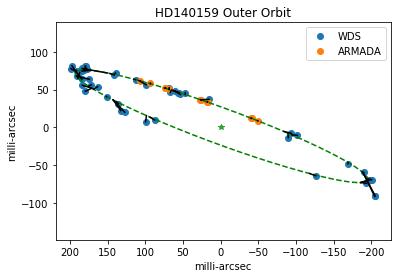

In [15]:
###########################################
## Do a least-squares fit
###########################################
params = Parameters()
params.add('w',   value= omega, min=0, max=360)
params.add('bigw', value= bigomega, min=0, max=360)
params.add('inc', value= inc, min=0, max=180)
params.add('e', value= e, min=0, max=0.99)
params.add('a', value= a, min=0)
params.add('P', value= P, min=0)
params.add('T', value= T, min=0)
params.add('mirc_scale', value= 1.0, vary=False)

result = ls_fit(params,xpos_all,ypos_all,t_all,error_maj_all,error_min_all,error_pa_all)

In [16]:
resids_armada = astrometry_model(result.params,xpos,ypos,t,error_maj,
                            error_min,error_pa)
ndata_armada = 2*sum(~np.isnan(xpos))
chi2_armada = np.nansum(resids_armada**2)/(ndata_armada-len(result.params))
print('-'*10)
print('chi2 armada = %s'%chi2_armada)
print('-'*10)

----------
chi2 armada = 53.76920888403943
----------


In [17]:
scale=1
if chi2_armada<1.0:
    scale=1/np.sqrt(chi2_armada)
a_start = result.params['a']
P_start = result.params['P']
e_start = result.params['e']
inc_start = result.params['inc']
w_start = result.params['w']
bigw_start = result.params['bigw']
T_start = result.params['T']
ra,dec,rapoints,decpoints = orbit_model(a_start,e_start,inc_start,
                                        w_start,bigw_start,P_start,
                                        T_start,t_all)

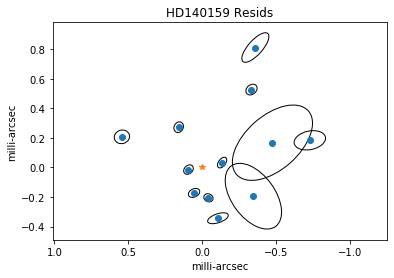

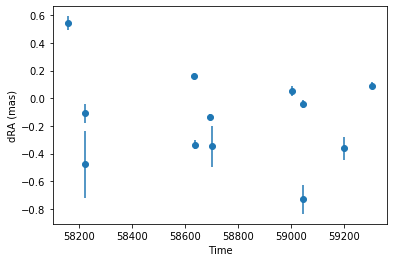

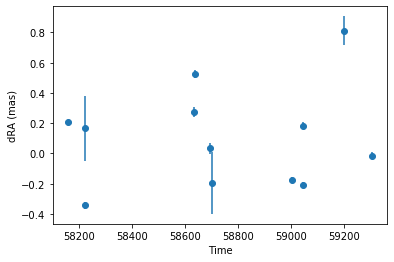

----------
Mean residual = 379.58 micro-as
----------


In [18]:
## plot resids for ARMADA
fig,ax=plt.subplots()
xresid = xpos - rapoints[:len(xpos)]
yresid = ypos - decpoints[:len(ypos)]

#need to measure error ellipse angle east of north
for ras, decs, w, h, angle in zip(xresid,yresid,error_maj/scale,error_min/scale,error_deg):
    ellipse = Ellipse(xy=(ras, decs), width=2*w, height=2*h, 
                      angle=90-angle, facecolor='none', edgecolor='black')
    ax.add_patch(ellipse)

ax.plot(xresid, yresid, 'o')
ax.plot(0,0,'*')
ax.set_xlabel('milli-arcsec')
ax.set_ylabel('milli-arcsec')
ax.invert_xaxis()
ax.axis('equal')
ax.set_title('HD%s Resids'%target_hd)
plt.show()

plt.errorbar(t,xresid,yerr=error_maj/scale*np.sin(error_deg*np.pi/180),fmt='o')
plt.xlabel('Time')
plt.ylabel('dRA (mas)')
plt.show()

plt.errorbar(t,yresid,yerr=error_maj/scale*np.cos(error_deg*np.pi/180),fmt='o')
plt.xlabel('Time')
plt.ylabel('dRA (mas)')
plt.show()

## residuals
resids = np.sqrt(xresid**2 + yresid**2)
resids_median = np.around(np.median(resids)*1000,2)
print('-'*10)
print('Mean residual = %s micro-as'%resids_median)
print('-'*10)

In [19]:
##########################################
## Grid Search for Additional Companions
##########################################

## New test -- try period spacing from PHASES III paper
time_span = max(t) - min(t)
print('Time span of data = %s days'%time_span)
f = 3
min_per = 2
max_k = int(2*f*time_span / min_per)
k_range = np.arange(max_k)[:-1] + 1
P2 = 2*f*time_span / k_range
print('Min/Max period (days) = %s / %s ; %s steps'%(min(P2),max(P2),len(k_range)))

ss = 0.01
se = 1
#P2 = np.linspace(ps,pe,steps)
#P2 = np.logspace(np.log10(ps),np.log10(pe),1000)

a2 = resids_median/1000
if np.isnan(a2):
    a2=1
#T2 = 55075

Time span of data = 1145.8313999999955 days
Min/Max period (days) = 2.0008697322467905 / 6874.988399999973 ; 3436 steps


In [23]:
print('Grid Searching over period')
params_inner=[]
params_outer=[]
chi2 = []

for period in tqdm(P2):

    omega_step = 2*np.pi/period

    params = Parameters()
    params.add('w',   value= w_start, min=0, max=360)
    params.add('bigw', value= bigw_start, min=0, max=360)
    params.add('inc', value= inc_start, min=0, max=180)
    params.add('e', value= e_start, min=0, max=0.99)
    params.add('a', value= a_start, min=0)
    params.add('P', value= P_start, min=0)
    params.add('T', value= T_start, min=0)
    
    params.add('a_x',   value=0)
    params.add('a_y', value=0)
    params.add('phase_x', value= 0)
    params.add('phase_y', value= 0)
    params.add('omega', value= omega_step, vary=False)
    if mirc_scale == 'y':
        params.add('mirc_scale', value= 1.0)
    else:
        params.add('mirc_scale', value= 1.0, vary=False)

    #params.add('pscale', value=1)

    #do fit, minimizer uses LM for least square fitting of model to data
    minner = Minimizer(triple_model_sinusoid, params, fcn_args=(xpos_all,ypos_all,t_all,
                                                       error_maj_all,error_min_all,
                                                       error_pa_all),
                      nan_policy='omit')
    result = minner.leastsq(xtol=1e-5,ftol=1e-5)
    params_inner.append([period,result.params['a_x'],result.params['a_y'],result.params['phase_x']
                        ,result.params['phase_y']])
    params_outer.append([result.params['P'],result.params['a'],result.params['e'],result.params['w']
                        ,result.params['bigw'],result.params['inc'],result.params['T']])
    chi2.append(result.chisqr)
    #print([period,result.params['a_x'],result.params['a_y'],result.params['phase_x']
    #                    ,result.params['phase_y']])
    #print([result.params['P'],result.params['a'],result.params['e'],result.params['w']
    #                    ,result.params['bigw'],result.params['inc'],result.params['T']])
    #print(result.chisqr)

  0%|          | 0/3436 [00:00<?, ?it/s]

Grid Searching over period


100%|██████████| 3436/3436 [21:18<00:00,  2.69it/s] 


In [24]:
params_inner=np.array(params_inner)
params_outer=np.array(params_outer)
chi2 = np.array(chi2)
#chi2_noise = np.array(chi2_noise)

#idx = np.argmin(chi2)
idx = np.argmin(chi2)
period_best = params_inner[:,0][idx]

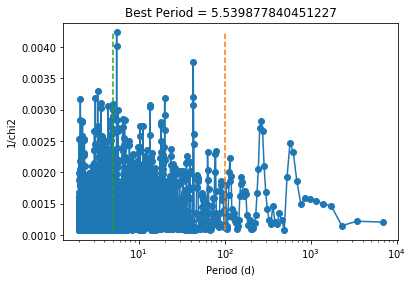

In [25]:
plt.plot(params_inner[:,0],1/chi2,'o-')
plt.plot([pper,pper],[min(1/chi2),max(1/chi2)],'--',label='%s uas'%psem*1000)
plt.plot([pper2,pper2],[min(1/chi2),max(1/chi2)],'--',label='%s uas'%psem2*1000)
plt.xscale('log')
plt.xlabel('Period (d)')
plt.ylabel('1/chi2')
plt.title('Best Period = %s'%period_best)
plt.show()

In [31]:
print('P,a2,e2,w2,bigw2,inc2,T2')
print(params_inner[idx])
print(params_outer[idx])

P,a2,e2,w2,bigw2,inc2,T2
[ 5.53987784  0.21568883  0.48586916  1.32736858 -1.02921278]
[8.01742328e+03 2.11380870e+02 9.70556165e-02 7.81043318e+01
 6.96259332e+01 8.36364611e+01 5.41185385e+04]


In [32]:
P_start = params_outer[:,0][idx]
a_start = params_outer[:,1][idx]
e_start = params_outer[:,2][idx]
w_start = params_outer[:,3][idx]
bigw_start = params_outer[:,4][idx]
inc_start = params_outer[:,5][idx]
T_start = params_outer[:,6][idx]

P2_start = params_inner[:,0][idx]
a_x_start = params_inner[:,1][idx]
a_y_start = params_inner[:,2][idx]
phase_x_start = params_inner[:,3][idx]
phase_y_start = params_inner[:,4][idx]

## Try a quadruple search

In [34]:
print('Grid Searching over period')
params_inner1=[]
params_inner2=[]
params_outer_quad=[]
chi2_quad = []

for period in tqdm(P2):
    
    omega_step = 2*np.pi/period

    params_inner1_n=[]
    params_inner2_n=[]
    params_outer_n=[]
    chi2_n = []

    params = Parameters()
    params.add('w',   value= w_start, min=0, max=360)
    params.add('bigw', value= bigw_start, min=0, max=360)
    params.add('inc', value= inc_start, min=0, max=180)
    params.add('e', value= e_start, min=0, max=0.99)
    params.add('a', value= a_start, min=0)
    params.add('P', value= P_start, min=0)
    params.add('T', value= T_start, min=0)
        
    params.add('a_x',   value=a_x_start)
    params.add('a_y', value=a_y_start)
    params.add('phase_x', value= phase_x_start)
    params.add('phase_y', value= phase_y_start)
    params.add('omega', value= 2*np.pi/P2_start, min=0)
        
    params.add('a_x_2',   value=0)
    params.add('a_y_2', value=0)
    params.add('phase_x_2', value= 0)
    params.add('phase_y_2', value= 0)
    params.add('omega_2', value= omega_step, vary=False)
        
    if mirc_scale == 'y':
        params.add('mirc_scale', value= 1.0)
    else:
        params.add('mirc_scale', value= 1.0, vary=False)

    #params.add('pscale', value=1)

    #do fit, minimizer uses LM for least square fitting of model to data
    minner = Minimizer(quad_model_sinusoid, params, fcn_args=(xpos_all,ypos_all,t_all,
                                                       error_maj_all,error_min_all,
                                                       error_pa_all),
                      nan_policy='omit')
    result = minner.leastsq(xtol=1e-5,ftol=1e-5)
    params_inner1.append([period,result.params['a_x_2'],result.params['a_y_2'],result.params['phase_x_2']
                        ,result.params['phase_y_2']])
    params_inner2.append([2*np.pi/result.params['omega'],result.params['a_x'],result.params['a_y'],result.params['phase_x']
                        ,result.params['phase_y']])
    params_outer_quad.append([result.params['P'],result.params['a'],result.params['e'],result.params['w']
                        ,result.params['bigw'],result.params['inc'],result.params['T']])
    chi2_quad.append(result.chisqr)

  0%|          | 0/3436 [00:00<?, ?it/s]

Grid Searching over period


100%|██████████| 3436/3436 [20:34<00:00,  2.78it/s] 


In [35]:
params_inner1=np.array(params_inner1)
params_inner2=np.array(params_inner2)
params_outer_quad=np.array(params_outer_quad)
chi2_quad = np.array(chi2_quad)

np.save('/Users/tgardne/binary_interferometry/params_inner1_sinusoid_method_saved.npy',params_inner1)
np.save('/Users/tgardne/binary_interferometry/params_inner2_sinusoid_method_saved.npy',params_inner2)
np.save('/Users/tgardne/binary_interferometry/params_outer_quad_sinusoid_method_saved.npy',params_outer_quad)
np.save('/Users/tgardne/binary_interferometry/chi2_quad_sinusoid_method_saved.npy',chi2_quad)

In [36]:
idx = np.argmin(chi2_quad)
period_best1 = params_inner1[:,0][idx]
period_best2 = params_inner2[:,0][idx]

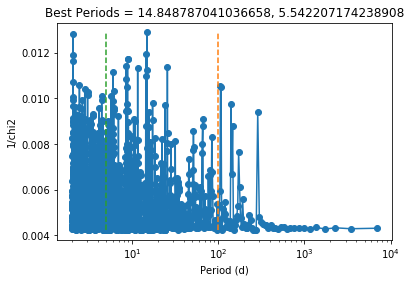

In [37]:
plt.plot(params_inner1[:,0],1/chi2_quad,'o-')
plt.plot([pper,pper],[min(1/chi2_quad),max(1/chi2_quad)],'--',label='%s uas'%psem*1000)
plt.plot([pper2,pper2],[min(1/chi2_quad),max(1/chi2_quad)],'--',label='%s uas'%psem2*1000)
plt.xscale('log')
plt.xlabel('Period (d)')
plt.ylabel('1/chi2')
plt.title('Best Periods = %s, %s'%(period_best1,period_best2))
plt.show()

In [38]:
## Best fit 
params = Parameters()
params.add('w',   value= params_outer[:,3][idx], min=0, max=360)
params.add('bigw', value= params_outer[:,4][idx], min=0, max=360)
params.add('inc', value= params_outer[:,5][idx], min=0, max=180)
params.add('e', value= params_outer[:,2][idx], min=0, max=0.99)
params.add('a', value= params_outer[:,1][idx], min=0)
params.add('P', value= params_outer[:,0][idx], min=0)
params.add('T', value= params_outer[:,6][idx], min=0)

params.add('a_x',   value=params_inner2[:,1][idx])
params.add('a_y', value=params_inner2[:,2][idx])
params.add('phase_x', value= params_inner2[:,3][idx])
params.add('phase_y', value= params_inner2[:,4][idx])
params.add('omega', value= 2*np.pi/params_inner2[:,0][idx], min=0)
        
params.add('a_x_2',   value=params_inner1[:,1][idx])
params.add('a_y_2', value=params_inner1[:,2][idx])
params.add('phase_x_2', value= params_inner1[:,3][idx])
params.add('phase_y_2', value= params_inner1[:,4][idx])
params.add('omega_2', value= 2*np.pi/params_inner1[:,0][idx], min=0)
        
if mirc_scale == 'y':
    params.add('mirc_scale', value= 1.0)
else:
    params.add('mirc_scale', value= 1.0, vary=False)

#params.add('pscale', value=1)

#do fit, minimizer uses LM for least square fitting of model to data
minner = Minimizer(quad_model_sinusoid, params, fcn_args=(xpos_all,ypos_all,t_all,
                                                   error_maj_all,error_min_all,
                                                   error_pa_all),
                  nan_policy='omit')
result = minner.minimize()
report_fit(result)     

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 223
    # data points      = 120
    # variables        = 17
    chi-square         = 76.3581837
    reduced chi-square = 0.74134159
    Akaike info crit   = -20.2467836
    Bayesian info crit = 27.1405760
[[Variables]]
    w:           78.0659094 +/- 2.36159542 (3.03%) (init = 82.80783)
    bigw:        69.6313069 +/- 0.03500091 (0.05%) (init = 69.78907)
    inc:         83.6241826 +/- 0.04280978 (0.05%) (init = 83.43683)
    e:           0.09628066 +/- 0.00447358 (4.65%) (init = 0.07620741)
    a:           211.195217 +/- 0.69868804 (0.33%) (init = 208.0472)
    P:           8018.11544 +/- 7.62498751 (0.10%) (init = 8023.455)
    T:           54118.2529 +/- 63.3491761 (0.12%) (init = 54251.03)
    a_x:         0.30546747 +/- 0.01914665 (6.27%) (init = 0.3071467)
    a_y:         0.42231841 +/- 0.02092082 (4.95%) (init = 0.4279427)
    phase_x:     29.4097016 +/- 7.60527374 (25.86%) (init = 29.16599)
    phas

In [39]:
print(bigw_injected1,inc_injected1,t0_injected1)
print(bigw_injected2,inc_injected2,t0_injected2)

44.47967732937861 87.8719560917765 59274.55635647252
163.5503256909315 158.1278496695906 58986.37172110323
